In [263]:
import numpy as np
from sexpdata import loads, dumps, Symbol
from matplotlib import pyplot as plt

In [255]:
def isArr(x): return isinstance(x, np.ndarray)
def sing(x): return np.array([x])
def unsing(x): return x[0] if len(x) == 1 else x
def isNum(x): return type(x) in (int, float)

In [238]:
class Agent():
    def __init__(self, i=1, s=8, o=1, M=None):
        self.seti(i)
        self.sets(s)
        self.seto(o)
        self.setM(M)
        
    def seti(self, i=1):
        self.i = i if isArr(i) else np.zeros(i)
        self.si = len(self.i)
    def sets(self, s=8):
        self.s = s if isArr(s) else np.zeros(s)
        self.ss = len(self.s)
    def seto(self, o=1):
        self.o = o if isArr(o) else np.zeros(o)
        self.so = len(self.o)
    def setM(self, M=None):
        self.M = M if isArr(M) else np.zeros((1*(self.si+self.ss+self.so), self.ss+self.so))

    def step(self, i):
        self.i = i if isArr(i) else sing(i)
        v = np.concatenate([self.i, self.s, self.o])        # in ++ state ++ out
        w = np.dot(v, self.M)                               # update
        self.s, self.o = w[:-self.so], w[-self.so:]         # state ++ out
        return self.o

    def trace(self, inputs): return [unsing(self.step(i)) for i in inputs]

In [256]:
# ex in: (d (d i))
# ex ir: {((0, 1),): 1, ((0, 1), (1, -1)): 2, ((2, 1),): 3, ((2, 1), (3, -1)): 4}
# ex out: Agent(1, 3, 1, M) with shape(M)==(5,4)
def comp(expr, s=None):
    t = loads(expr)

    c = [0]
    def newSym():
        c[0] += 1
        return c[0]

    p2s = {}
    def node(*p):
        p = tuple(sorted(p))
        if p not in p2s:
            s = newSym()
            p2s[p] = s
        return p2s[p]

    def toMono(t):
        if isinstance(t, list) and str(t[0]) == "Symbol('*')" and len(t) == 3: # match t with [*, x, y]
            if isNum(t[1]): return t      # ex: (* 3 i) ~> (* 3 i)
            if isNum(t[2]): 
                return [Symbol('*'), t[2], t[1]]    # ex: (* i 2) ~> (* 2 i)
        return [Symbol('*'), 1, t]                  # ex: i       ~> (* 1 i)

    def f(t):
        if   str(t) == "Symbol('i')": return  0   # TODO: yuck
        elif str(t) == "Symbol('o')": return -1   # TODO: yuck
        elif str(t) == "Symbol('r')": return -2   # TODO: yuck
        elif str(t[0]) == "Symbol('d')":
            x = f(t[1])
            xlag = node((x, 1))
            return node((x, 1), (xlag, -1))
        elif str(t[0]) == "Symbol('+')":
            args = map(toMono, t[1:])
            return node(*[(f(a[2]), a[1]) for a in args])
        elif str(t[0]) == "Symbol('-')":
            x, y = f(t[1]), f(t[2])
            return node((x, 1), (y, -1))
        elif str(t[0]) == "Symbol('int')":
            x = f(t[1])
            return node((x, 1), (-2, 1))    # -2 hacks recursion

    n = f(t)

    M = np.zeros((n+1, n))
    for p, s in p2s.items(): 
        # print(s, p)
        for s2, c in p: 
            if s2 == -2: s2 = s # hack recursion
            M[s2][s-1] += c

    return Agent(1, n-1, 1, M)


In [242]:
# #              s0  s1  o             
# M = np.array([[1,  0,  0.5],    # i
#               [0,  1, -1.0],    # s0
#               [0,  0,  0.5],    # s1
#               [0,  0,  0],])    # o

# #              s0  s1  s2  o             
# N = np.array([[1,  1,  0,  0],    # i
#               [0, -1,  0,  0],    # s0
#               [0,  0,  1,  1],    # s1
#               [0,  0,  0, -1],    # s2
#               [0,  0,  0,  0],])  # o

# a = comp("(d (d (d i)))")   # third derivative
# a = comp("(+ (d (d i)) i)")
# a = comp("(+ (d (d (d i))) o o)")

# a = comp("(int (d i))")
# a = comp("(+ (d i) o)")
a = comp("(+ (- i (+ i)) o)")

print(a.M)
inputs = [x*x for x in range(1,10)]
print(inputs)
a.trace(inputs)

[[ 1.  1.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
[1, 4, 9, 16, 25, 36, 49, 64, 81]


[0.0, 1.0, 4.0, 9.0, 16.0, 25.0, 36.0, 49.0, 64.0]

[[ 1.   1.   1.   0.4]
 [ 1.   0.   0.   0.2]
 [ 0.   0.  -1.   0. ]
 [ 0.   0.   0.   0.1]
 [ 0.   0.   0.   0. ]]


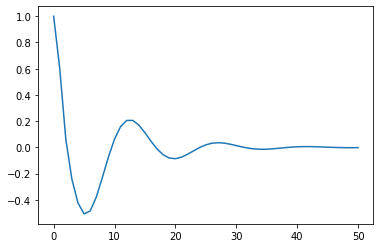

In [274]:
# i: the error
# o: the adjustment
a = comp("(+ (* 0.4 i) (* 0.2 (int i)) (* 0.1 (d i)))")
print(a.M)

L = []
def store(x):
    # print(f"x: {x}")
    L.append(x)

x = 1
store(x)
for _ in range(50):
    x += unsing(a.step(-x)) # -x is the error
    store(x)

plt.plot(L)